In [1]:
import geopandas as gpd
from glob import glob
import matplotlib.pyplot as plt
import os
import rioxarray as rio
import xarray as xr
# from dem_utils import ArcticDEM
# from itertools import product
# import dask
# from dask.distributed import LocalCluster, Client
# import numpy as np
import pandas as pd
import numpy as np
# import utils
# from shapely import wkt
import cartopy.crs as ccrs
# import planetary_computer as pc
# import pystac_client
# from pystac.extensions.eo import EOExtension as eo
# import rioxarray as rio
# import stackstac
# import shapely


In [5]:
directory = '../data/id18_1364036x_-2507363y/'
corgd_dem_files = [os.path.join(directory, f) for f in glob('coregd_*', root_dir=directory)]
centreline = gpd.read_file(
    os.path.join(directory, glob('line*.geojson', root_dir=directory)[0])
)
centreline_wkt = centreline.loc[0, 'geometry'].wkt
metafile = glob('*.parquet', root_dir=directory)
meta = pd.read_parquet(os.path.join(directory, metafile[0]))
meta['to_reg_acqdate1'] = meta['to_reg_acqdate1'].astype('datetime64[ns]')
meta['ref_acqdate1'] = meta['ref_acqdate1'].astype('datetime64[ns]')
sec_files = glob('sec*', root_dir=directory)

In [6]:
prj = ccrs.Stereographic(
    central_latitude=90,
    central_longitude=-45,
    true_scale_latitude=70
)

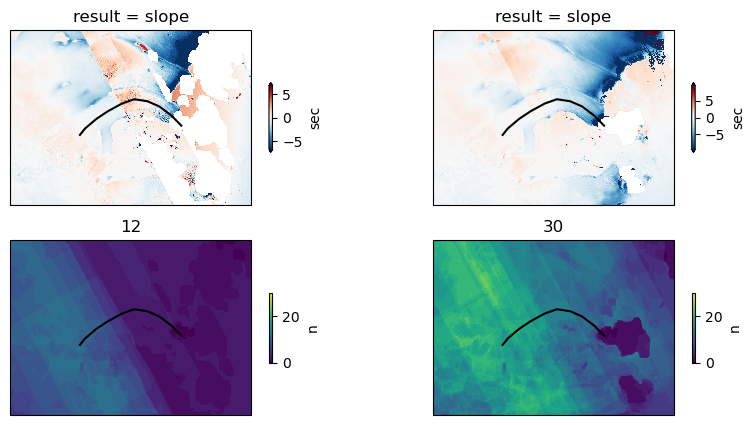

In [10]:
fig, axs = plt.subplots(#figsize=[10,5],
                        ncols=len(sec_files),
                        nrows=2,
                        subplot_kw={'projection': prj})

for sec, ax_hi, ax_lo in zip(sec_files, axs[0,:], axs[1,:]):
    
    with xr.open_dataset(os.path.join(directory, sec),
                         engine='zarr') as ds:
        
        ds['sec'].sel(result='slope').plot(robust=True, ax=ax_hi, cbar_kwargs={'shrink':0.4})
        
        ds['n'].plot(ax=ax_lo, cbar_kwargs={'shrink':0.4}, vmin=0, vmax=30)
        ax_lo.set_title(len(ds.attrs['dem_ids']))

for ax in axs.flat:
    centreline.plot(ax=ax, color='k')

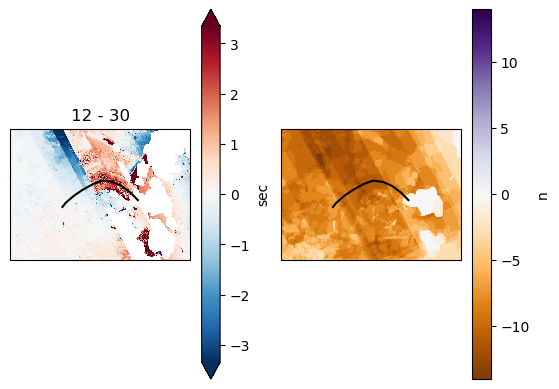

In [19]:

fig, axs = plt.subplots(ncols=2, subplot_kw={'projection':prj})
with xr.open_dataset(os.path.join(directory, sec_files[0]), engine='zarr') as a:
    with xr.open_dataset(os.path.join(directory, sec_files[1]), engine='zarr') as b:
        (a['sec'].sel(result='slope') - b['sec'].sel(result='slope') ).plot(robust=True, ax=axs[0])
        (a['n'] - b['n']).plot(ax=axs[1], cmap='PuOr')
        axs[0].set_title(f"{len(a.attrs['dem_ids'])} - {len(b.attrs['dem_ids'])}")

for ax in axs:
    centreline.plot(ax=ax, color='k')
    

In [ ]:
import seaborn as sns
def plot_stat(df, stat, ax):
    # df = get_meta_df(d)
    after = f'{stat}_after'
    before = f'{stat}_before'
    for row in df.iterrows():
        # print(row[0])
        ax.annotate("",
                    xy=(row[1]['to_reg_acqdate1'], row[1][after]),
                    xytext=(row[1]['to_reg_acqdate1'], row[1][before]),
                    arrowprops=dict(arrowstyle='->'))
    
    minx, maxx = df['to_reg_acqdate1'].agg(['min','max'])
    delta = pd.Timedelta('90d')
    ax.set_xlim(minx-delta, maxx+delta)
    ax.set_ylim(*df[[after, before]].melt()['value'].agg(['min','max']))
    
    ax.axhline(0, c='lightgrey', lw=0.5)
    ax.axvline(df.ref_acqdate1.unique()[0], ls=':', c='k')
    ax.set_ylabel(f'{stat} (m)')
    for label in ax.get_xticklabels(which='major'):
        label.set(rotation=30, horizontalalignment='center')

def plot_coreg(df, ax):
    # df = get_meta_df(d)
    
    plot_df = df[['median_after','median_before','nmad_after','nmad_before']].melt()
    plot_df['when'] = plot_df['variable'].str.split('_').apply(lambda x: x[1])
    plot_df['variable'] = plot_df['variable'].str.split('_').apply(lambda x: x[0])
    sns.violinplot(data=plot_df,
                   x='variable',
                   y='value',
                   hue='when',
                   palette=sns.palettes.color_palette('colorblind')[-2:],
                   hue_order=['before','after'],
                   ax=ax)
    ax.set_ylabel('metres')
    ax.set_xlabel(None)
    ax.axhline(0, c='lightgrey', lw=0.5, zorder=0)
    sns.move_legend(ax, loc='best', title=None)

## velocity

In [ ]:
from dask.distributed import Client, LocalCluster
import pandas as pd
# import itslive
import geopandas as gpd
# from shapely.geometry import Polygon
# from shapely import box
import matplotlib.pyplot as plt
# from matplotlib.collections import LineCollection
# from matplotlib.dates import date2num, DateFormatter, YearLocator
# import seaborn as sns
# import xrspatial as xrs
import numpy as np
import xarray as xr
from tqdm import tqdm
from IPython import display
import importlib
# import imagery
import utils
import velocity_helpers

In [ ]:
# _ = importlib.reload(utils)
# _ = importlib.reload(velocity_helpers)
# _ = importlib.reload(imagery)

In [ ]:
cluster = LocalCluster()
client = Client(cluster)
print(client.dashboard_link)

In [ ]:
## read in lines, and lazily get velocity cubes, centrelines, and robust trends
lines = gpd.read_file('../data/streams_v2.geojson').to_crs(3413)

In [ ]:
V = {}
failed = []
for row in tqdm(lines.sample(3).itertuples()):
    print(f'working on #{row.Index}')
    try:
        V[row.Index] = velocity_helpers.CentreLiner(
            geo=row.geometry,
            buff_dist=500,
            index=row.Index,
            filter_cube=False,
            get_robust_trend=True,
            get_annual_median=False,
            get_rgb=False,
            )
    except Exception as e:
        failed.append((row.Index, e))
        print(f'#{row.Index} did not work because\n{e}')
        continue

## plotting

In [ ]:
fig, axs = plt.subplots(figsize=[15,8],
                        nrows=2,
                        ncols=4,
                        sharex=True,
                        sharey=True)

for k_v, ax in zip(V.items(), axs.flat):
    k, v = k_v
    velocity_helpers.Plotters.rolling_median(v,
                                             ax=ax,
                                         **{'var': 'v',
                                            'ddt_range': ('335d','395d'),
                                            'ddt_bars': False,
                                            'col': 'cumul_dist',
                                            'window': '90d',
                                            'vals':[500, 1_000, 3_000, 5_000]
                                            })
    _point = utils.shapely_reprojector(v.point, 3413, 4326)
    
    ax.set_title(f'#{k}: {_point.y:.2f}N {_point.x:.2f}W\n{lines.loc[k,"name"]}')
    ax.minorticks_off()

# axs.flat[-2].remove()
axs.flat[-1].remove()

now = pd.Timestamp.now().strftime('%y%m%d_%H%M')+ '_'
directory = '../../GitHub/diary/journal_figures'
filename = 'iceland_outlets_annual_v.png'
fig.savefig(directory + now + filename, bbox_inches = 'tight')

In [ ]:
def centreline_theil_slopes(df, **kwargs):
    
    _var = kwargs.get('var', 'v')
    _x = kwargs.get('x', 'mid_date')
    _date_range = kwargs.get('date_range', (pd.Timestamp('1900-01-01'),
                                            pd.Timestamp.now()))
    _ddt_range = kwargs.get('ddt_range', ('0d', '30d'))
    _mad = kwargs.get('mad', 3)
    
    _df = df.loc[df[_x].between(*_date_range)]    

In [ ]:
idx = ((ds['date_dt'] > pd.Timedelta('335d')) & ((ds['date_dt'] <= pd.Timedelta('395d')))).compute()

from scipy.stats.mstats import theilslopes
from scipy.stats import linregress

x = (ds.mid_date[idx] - ds.mid_date[idx].min()) / pd.Timedelta('365.25d')
y = ds['v'][idx,50,50].compute()

nan_idx = y.isnull()

x = x[~nan_idx]
y= y[~nan_idx]

theil_result = theilslopes(y=y, x=x)
lr_result = linregress(x=x, y=y)


X = np.arange(0,30)
theil_fit = (X * theil_result.slope) + theil_result.intercept
lr_fit = (X * lr_result.slope) + lr_result.intercept

fig, ax = plt.subplots()
ax.scatter(x,y)

ax.plot(X, theil_fit, c='r', label='theilslopes')
ax.plot(X, lr_fit, c='g', label='lr')
ax.legend()

In [ ]:
fig, axs = plt.subplots(figsize=[15,8], nrows=5, ncols=3)
# get_velocity.Plotters.date_dt_bars(V[13],
#                                    ('1d','15d'),
#                                    ax=ax,
#                                    **{'vals':[5_000,1_000]})

get_velocity.Plotters.rolling_median(V[13],
                                     ('335d','395d'),
                                     ax=ax,
                                     ddt_bars=False,
                                     **{'var': 'v',
                                        'col': 'cumul_dist',
                                        'window': '180d',
                                        'vals':[1_000, 3_000, 5_000, 10_000]})

- look at underlying dodgy velocity images
TODO look at GRIMpP and MEASUREs

TODO
- PN thinks that relative change is sufficient to *control* for variations in glacier geometry (read: width/size).
- most interested in *relative* change of velocity over final few kilometers.
    - i.e. 

- it all comes from the same raw processed v data

## imagery

In [ ]:
study_sites = gpd.read_file('../data/potential_study_sites_v1.geojson')
study_sites = study_sites.loc[study_sites['notes'].isin(['yes', 'maybe'])]
study_sites.reset_index(drop=True, inplace=True)
study_sites_5k = study_sites.buffer(5_000).to_crs(4326)

In [ ]:
items = imagery.get_annual_median_mosaic(
    study_sites.loc[0,'geometry'],
    buffer_dist=15_000,
    src_crs=study_sites.crs,
    target_crs=4326,
    timeperiod='2023-01-01/2024-01-01',
    months=[8,9],
    )

In [ ]:
(xrs.multispectral.true_color(
    *items.squeeze()
    .transpose('band', 'y', 'x'))
 .plot.imshow(rgb='band')
)

In [ ]:
import stackstac
stackstac.stack(items, assets=['B04', 'B03', 'B02'])